In [1]:
# import packages

import pickle, pprint
import numpy as np
import collections
import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge, cell, colony, data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Load data structure at specified time

In [2]:
#Time step , checked - > t = 12, cut = 4, t=21, cut = 30
# Bad ones - 7, 16, 20, 21, 28, 29, 30 at cutoff = 1
# Checked - 28 -> cutoff = 40 , 29 diffuclt, 
# 20 is a good example for small cell healing stuff
t = 0
V = data(data1, t)

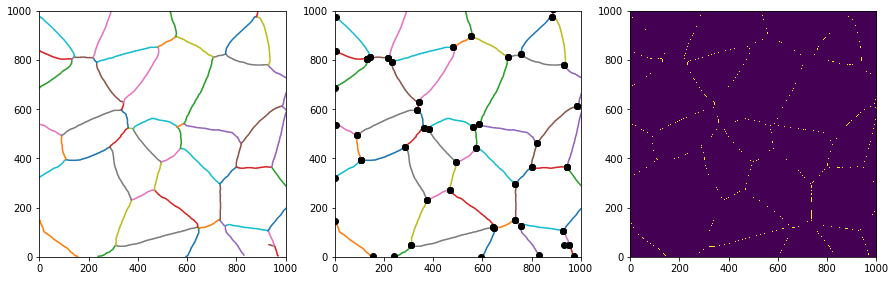

In [3]:
# Plot 
import matplotlib.pyplot as plt
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))
V.plot(ax, "edge", None)
V.plot(ax1, "edge_and_node", None)
V.plot(ax2, "image", None)

# Clean up overlapping nodes within small cutoff

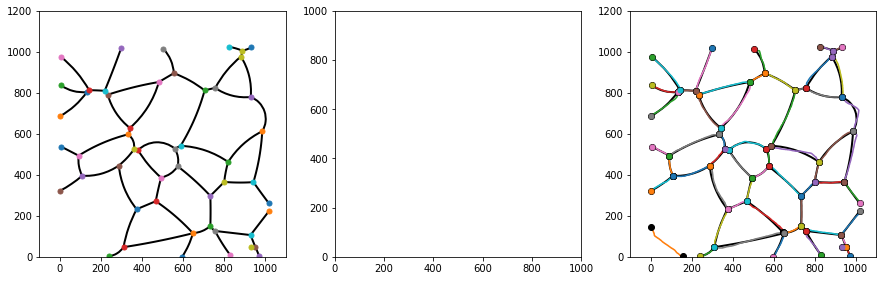

In [4]:
# Cutoff
cutoff = 10
nodes, edges, new_edges = V.post_processing(cutoff, None)
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

edges = [e for e in edges if e.radius is not None]

[e.plot(ax1) for e in new_edges]
[n.plot(ax1) for e in new_edges for n in e.nodes]

V.plot(ax2, "edge_and_node", None)
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
for a in (ax, ax2):
    a.set(xlim = [0,300], ylim = [400,600], aspect = 1)
#    a.set(xlim = [140,170], ylim = [400,420], aspect = 1)
    a.set(xlim = [-100,1100], ylim = [0,1200], aspect = 1)
    [e.plot(a, lw = 2 ) for e in edges]
    [n.plot(a, markersize = 10) for n in nodes]


In [5]:
# Check repeats
print([item for item, count in collections.Counter(nodes).items() if count > 1])
print([item for item, count in collections.Counter(edges).items() if count > 1])

[]
[]


In [5]:
print([len(n.edges) for n in nodes])

[1, 4, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 4, 1, 1, 1, 3, 1, 1, 3, 1, 1]


In [6]:
[set(n.edges) for n in nodes if len(n.edges) == 2][0]

{<cell_describe.edge at 0x10e216780>, <cell_describe.edge at 0x10e216898>}

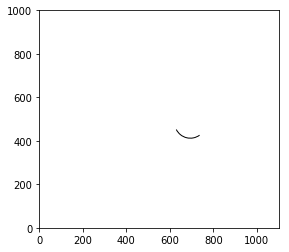

In [12]:
fig, ax = plt.subplots(1,1)
ax.set(xlim = [0,1100], ylim  = [0,1000], aspect = 1)
[e.plot(ax) for e in edges[19:20]]
plt.show()

In [13]:
edges[19].radius

72.1132395657534

# Compute tensions and pressures

In [8]:
col1, tensions, pressures, P_T, P_P, A, B = V.compute(cutoff)
print(len(col1.tot_edges))
print(len(col1.tot_nodes))
print('\n')
import numpy.linalg as la
print(la.cond(A))
print(la.cond(P_T))
print(la.cond(B))
print(la.cond(P_P))
print(np.mean(tensions))
if pressures is not None:
    print(np.mean(pressures))


61
51


17.709776734708797
234.05191786079442
7620156440511461.0
11.673993493980856
0.9999999999999999
-6.30808536718839e-19


# Plot

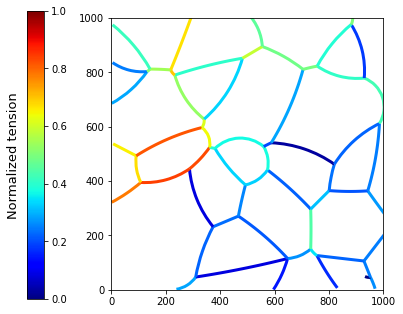

In [13]:
# Plot 
import pylab
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(8,5))
col1.plot_tensions(ax, fig, tensions)
pylab.savefig('0000{0}.png'.format(t), dpi=200)

In [6]:
# Make a movie

import os
fps = 1
os.system("rm movie.mp4")

os.system("ffmpeg -r "+str(fps)+" -b 1800 -i _tmp%05d.png movie.mp4")
os.system("rm _tmp*.png")

0

In [ ]:
# Show picture

from pylab import imread,subplot,imshow,show

import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
image = imread('00001.png')  

plt.imshow(image)

# Pressure stuff


In [11]:
np.array([c.pressure for c in col1.cells]).T

array([[ 1.72251716e-05, -1.84096047e-03,  1.30620421e-03,
        -2.27437055e-03, -1.95965561e-03,  1.45542778e-03,
         1.33552412e-02, -2.52908119e-04, -1.87047508e-03,
        -2.10858232e-03, -5.82714621e-03]])

8

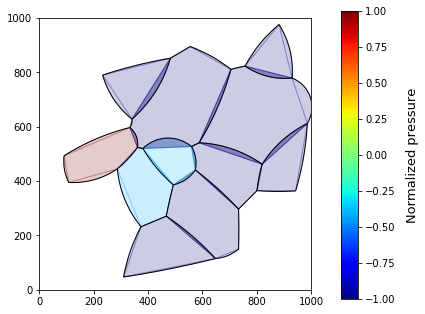

In [14]:
# Plot 
import pylab
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(8,5))

#col1.plot(ax, fig, tensions, pressures )
col1.plot_pressures(ax, fig, pressures )
[e.plot(ax) for e in col1.edges]
pylab.savefig('0000{0}.png'.format(t), dpi=200)

In [7]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def arc_patch(center, radius, theta1, theta2, ax=None, resolution=50, **kwargs):
    # make sure ax is not empty
    if ax is None:
        ax = plt.gca()
    # generate the points
    theta = np.linspace(np.radians(theta1), np.radians(theta2), resolution)
    points = np.vstack((radius*np.cos(theta) + center[0], 
                        radius*np.sin(theta) + center[1]))
    # build the polygon and add it to the axes
    poly = mpatches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly

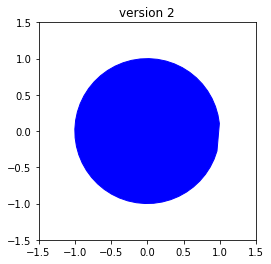

In [9]:
fig, ax = plt.subplots(1,1)

arc_patch((0,0), 1, 6, 360-16, ax, fill=True, color='blue')
ax.set_title('version 2')

# axis settings

ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

plt.show()

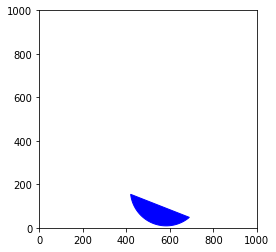

In [8]:
fig, ax = plt.subplots(1,1)

ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
edges[2].plot_fill(ax, color = 'blue') 

In [16]:
max(1,2)

2

# Find cells

In [12]:
pressures

array([-0.00316758, -0.00849867, -0.00303501, -0.00291798, -0.01547684,
        0.01051569,  0.04499283, -0.00335308, -0.0047372 , -0.00363343,
       -0.01678916, -0.00644213,  0.00682242,  0.00572014])

In [23]:
fname = '_tmp%05d.png'%1

In [24]:
print(fname)

_tmp00001.png


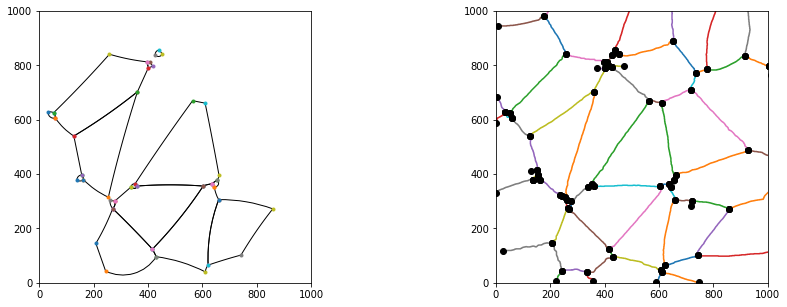

In [10]:
cells = V.find_cycles(edges)
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15,5))



ax.set_aspect(1)
ax.set(xlim = [0,1000], ylim = [0,1000])
[c.plot(ax) for c in cells]
V.plot(ax2, "edge_and_node", None)

plt.show()

In [9]:
cells[0].nodes

In [16]:
[sum([e.straight_length for e in cell.edges ]) for cell in cells]

[104.31913571565157,
 764.4339469751931,
 714.7710763229757,
 942.0865539919391,
 918.0578680763202,
 45.146491782057566,
 24.613969100219066,
 851.542689870816,
 834.5883489691737,
 870.6929689081796,
 1018.2010578808912,
 78.20509534092152,
 859.850097543139,
 908.5121977855248]

In [18]:
[a for a in [sum([e.straight_length for e in cell.edges ]) for cell in cells] if a < 100]

[45.146491782057566, 24.613969100219066, 78.20509534092152]

In [17]:
tot_perims = [sum([e.straight_length for e in cell.edges ]) for cell in cells]
print(tot_perims)

[104.31913571565157, 764.4339469751931, 714.7710763229757, 942.0865539919391, 918.0578680763202, 45.146491782057566, 24.613969100219066, 851.542689870816, 834.5883489691737, 870.6929689081796, 1018.2010578808912, 78.20509534092152, 859.850097543139, 908.5121977855248]


In [6]:
i = 11
fname = '_tmp%05d.png'%i
print(fname)

_tmp00011.png


In [11]:
[cell for cell in cells if cell.perimeter() < 100][0].edges

In [39]:
all_loc = [cells[0].nodes[i].loc for i in range(len(cells[0].nodes))]
x = [i[0] for i in all_loc]
print(np.mean(x))

611.3333333333334


In [45]:
nodes[0].edges[0].kill_edge(nodes[0])

In [48]:
nodes[0].edges[0].kill_edge(nodes[0])

In [56]:

edges[0].nodes
print(nodes[0].edges)
ed

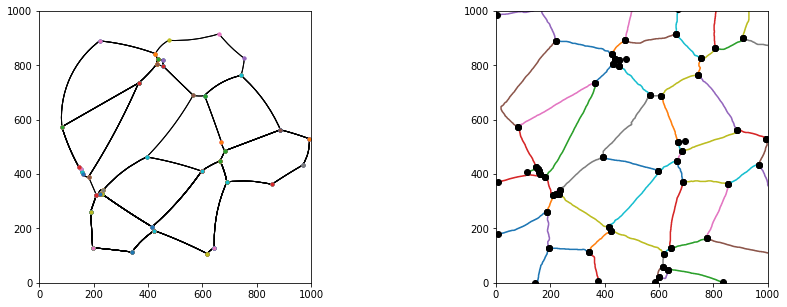

In [14]:
from Dave_cell_find import find_all_cells
cells = find_all_cells(edges)
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15,5))



ax.set_aspect(1)
ax.set(xlim = [0,1000], ylim = [0,1000])
[c.plot(ax) for c in cells]
V.plot(ax2, "edge_and_node", None)
plt.show()


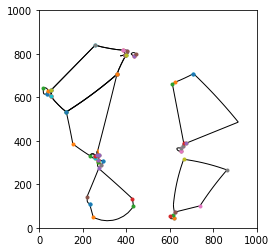

In [12]:
# Find cells

cells = []
max_iter = 100

for e in edges:
    cell = e.which_cell(edges, 1, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

    cell = e.which_cell(edges, 0, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

fig, ax = plt.subplots(1,1)
ax.set_aspect(1)
ax.set(xlim = [0,1000], ylim = [0,1000])
[c.plot(ax) for c in cells]
plt.show()

# Calculate tension and pressure

In [9]:
# Define colony and calculate tension. Then use that to find pressure

from cell_describe import colony 

edges2 = [e for e in edges if e.radius is not None]
col1 = colony(cells, edges2, nodes)

# A and B are the matrices. Tensions and pressures are values for each edge and cell respectively 

tensions, P_T = col1.calculate_tension()

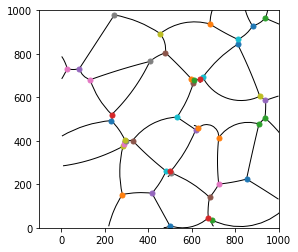

In [10]:
edges2 = [e for e in edges if e.radius is not None]
fig, ax = plt.subplots(1,1)
ax.set_aspect(1)
ax.set(xlim = [-100,1000], ylim = [0,1000])
[e.plot(ax) for e in edges2]
[e.plot(ax, markersize = 10) for e in nodes]

plt.show()

In [11]:
import numpy.linalg as la
print(la.cond(P_T))

10100.55575794979


In [19]:
t_edges = col1.cells[1].edges

In [20]:
# Check none of the radius is None
print([e.radius for e in t_edges])

[1620.580909465475, 2281.4162220554554, 458.4709047152761, 537.3431307583259]


In [10]:
pressures, P_P = col1.calculate_pressure(tensions)

In [6]:
tensions

array([2.02113844, 0.80894317, 0.76003775, 1.13047852, 0.85274066,
       0.92574534, 0.67710483, 0.53951188, 0.94154887, 0.65784759,
       1.63885728, 0.61525865, 0.50503216, 0.57155869, 0.28963243,
       0.12311102, 0.46964548, 0.70494489, 0.31406306, 0.63105894,
       0.82763772, 1.51326615, 1.19037647, 1.33821508, 1.87273769,
       1.24491681, 1.21576287, 0.39562731, 0.62129522, 1.52296017,
       1.08576941, 1.56062785, 0.9058295 , 0.70204496, 0.69717516,
       0.93832195, 1.95606995, 0.74750009, 0.75744499, 0.30720315,
       1.09040637, 0.54423332, 0.7744873 , 1.16661429, 1.12025262,
       1.13101782, 1.60423412, 1.33038205, 0.93139196, 0.43983833,
       0.82033163, 1.79289654, 2.37843721, 1.39007148, 1.270435  ,
       1.24234116, 1.7105841 , 0.22362619, 2.39583777, 0.60606785,
       0.34198024, 0.48164061, 1.41483147, 0.88238239, 1.33663601])

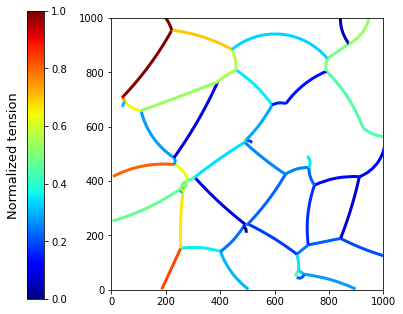

In [7]:
# Plot 
import pylab
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(8,5))
col1.plot_tensions(ax, fig, tensions)
# pylab.savefig('0000{0}.png'.format(0), dpi=200)

In [36]:
x = [1,2,3]
x.pop(1)
print(x)

[1, 3]


In [14]:
arr = tensions
mean = np.mean(arr)
sd = np.std(arr)

In [15]:
arr

array([ 1.98376077,  1.1852749 ,  1.29285086,  0.51487338,  0.39380486,
        1.41783929,  1.37942332,  1.51690892,  1.24995368,  1.04945523,
        1.46914004,  0.84086304,  0.59290173,  0.79696076,  0.51211785,
        0.54975829,  0.36022418,  0.44349956,  0.38696141,  0.37659647,
        0.37292638,  0.37368094,  0.21588087,  0.49942823,  0.24560425,
        0.20755444,  0.3945007 ,  0.16494537,  0.43410533,  0.31387398,
        0.22278462,  0.31046332,  0.3033347 ,  0.5050262 , 11.15259608,
       10.95868146,  1.2684031 ,  0.3808731 ,  0.64684685,  0.82395309,
        0.1315213 ,  0.34688414,  0.22694379,  0.78120809,  0.43650002,
        0.65507307,  0.43887463,  0.2763192 ,  0.21973537,  0.31806465,
        0.22005203,  0.35967638,  0.50444345,  0.69196231,  0.45492133,
        1.25959866,  0.8214423 ,  1.56216029,  1.97798692,  0.63730431,
        0.75682287,  0.60170163,  1.26078707,  0.61245129,  1.09444887,
        1.61708291,  1.79917299,  0.73524918,  0.78414901,  1.93

In [16]:
final_list = [x for x in arr if (x < mean - 3 * sd) or (x > mean + 3 * sd)]
print(final_list)


[11.152596075370914, 10.958681457797944]
2


In [27]:
np.where(arr - final_list[1] == 0)[0][0]

35

In [38]:
indices = [np.where(arr - final_list[i] == 0)[0][0] for i in range(len(final_list))]
print(indices)

[34, 35]


In [46]:
[edges[i] for i in indices]

[<cell_describe.edge at 0x13197a7e80>, <cell_describe.edge at 0x13197a7080>]

In [12]:
    def remove_outliers(tensions, nodes, edges):
        """
        Removing those edges that are giving tensions more than 3 std away from mean value
        """

        # Find mean and std
        mean = np.mean(tensions)
        sd = np.std(tensions)

        # Find tensions more than 3 standard deviations away
        bad_tensions = [x for x in tensions if (x < mean - 3 * sd) or (x > mean + 3 * sd)]
        
        # Find indices of bad tensions
        indices = [np.where(tensions - bad_tensions[i] == 0)[0][0] for i in range(len(bad_tensions))]

        bad_edges = [edges[i] for i in indices]
        for ed in bad_edges:
            ed.kill_edge(ed.node_a)
            ed.kill_edge(ed.node_b)
            if len(ed.node_a.edges) == 0:
                if ed.node_a in nodes:
                    nodes.remove(ed.node_a)
            if len(ed.node_b.edges) == 0:
                if ed.node_a in nodes:
                    nodes.remove(ed.node_a)
            edges.remove(ed)

        #return nodes, tensions

In [13]:
remove_outliers(tensions, nodes, edges)

In [17]:
a = []
a = 10
print(a)

10


Saving frame _tmp000.png
Saving frame _tmp001.png
Saving frame _tmp002.png
Saving frame _tmp003.png
Saving frame _tmp004.png
Saving frame _tmp005.png
Saving frame _tmp006.png
Saving frame _tmp007.png
Saving frame _tmp008.png
Saving frame _tmp009.png
Saving frame _tmp010.png
Saving frame _tmp011.png
Saving frame _tmp012.png
Saving frame _tmp013.png
Saving frame _tmp014.png
Saving frame _tmp015.png
Saving frame _tmp016.png
Saving frame _tmp017.png
Saving frame _tmp018.png
Saving frame _tmp019.png
Saving frame _tmp020.png
Saving frame _tmp021.png
Saving frame _tmp022.png
Saving frame _tmp023.png
Saving frame _tmp024.png
Saving frame _tmp025.png
Saving frame _tmp026.png
Saving frame _tmp027.png
Saving frame _tmp028.png
Saving frame _tmp029.png
Saving frame _tmp030.png
Saving frame _tmp031.png
Saving frame _tmp032.png
Saving frame _tmp033.png
Saving frame _tmp034.png
Saving frame _tmp035.png
Saving frame _tmp036.png
Saving frame _tmp037.png
Saving frame _tmp038.png
Saving frame _tmp039.png


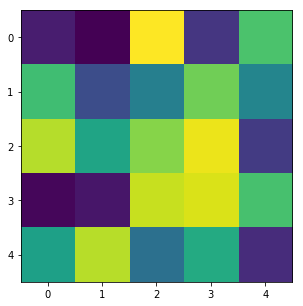

In [12]:
from __future__ import print_function

import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


files = []

fig, ax = plt.subplots(figsize=(5, 5))
for i in range(50):  # 50 frames
    plt.cla()
    plt.imshow(np.random.rand(5, 5), interpolation='nearest')
    fname = '_tmp%03d.png' % i
    print('Saving frame', fname)
    plt.savefig(fname)
    files.append(fname)

print('Making movie animation.mpg - this may take a while')
subprocess.call("mencoder 'mf://_tmp*.png' -mf type=png:fps=10 -ovc lavc "
                "-lavcopts vcodec=wmv2 -oac copy -o animation.mpg", shell=True)

# cleanup
for fname in files:
    os.remove(fname)

In [10]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [13]:
remove_outliers.__name__

NameError: name 'remove_outliers' is not defined

In [14]:
callable(V)

False

In [23]:
x = 2


In [24]:
try:
    x > 3
except x ==2:
    print('why')